In [1]:
# The following code is based on https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide

import pandas as pd
pd.options.display.max_columns = None
from datetime import datetime

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

df = pd.read_csv('../../output/cut-data.csv', usecols=['dates', 'occupancy'], index_col=0, parse_dates=[0])
df.index.freq = 'D'
df

,occupancy
dates,
2017-05-01,139
2017-05-02,135
2017-05-03,133
2017-05-04,133
2017-05-05,135
...,...
2019-03-27,129
2019-03-28,141
2019-03-29,142


In [3]:
import matplotlib.pyplot as plt

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

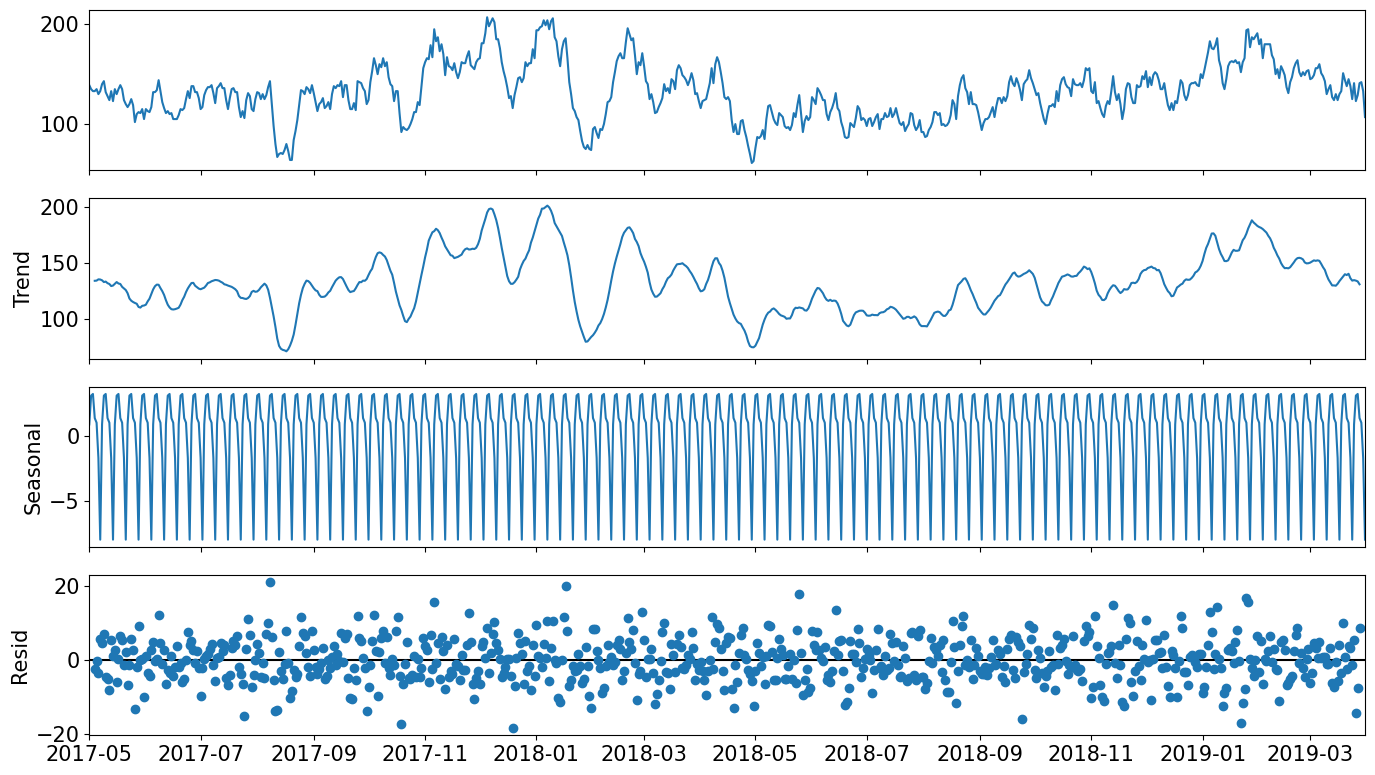

In [5]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(df,model='additive')
fig = result.plot()

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

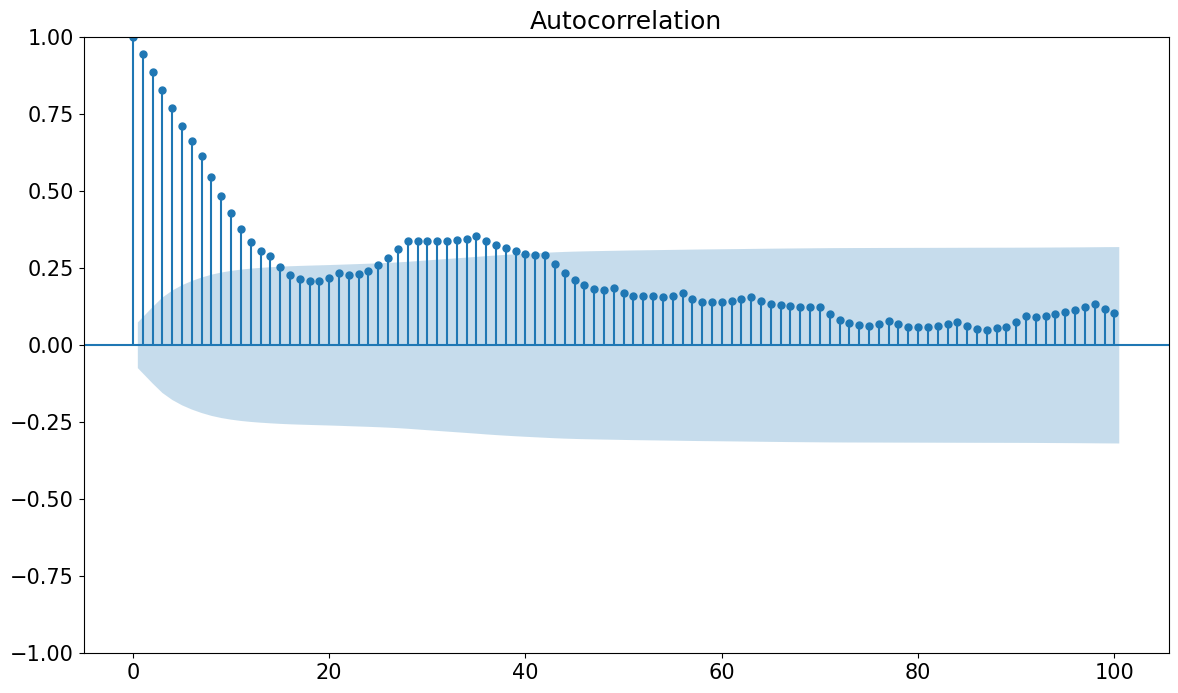

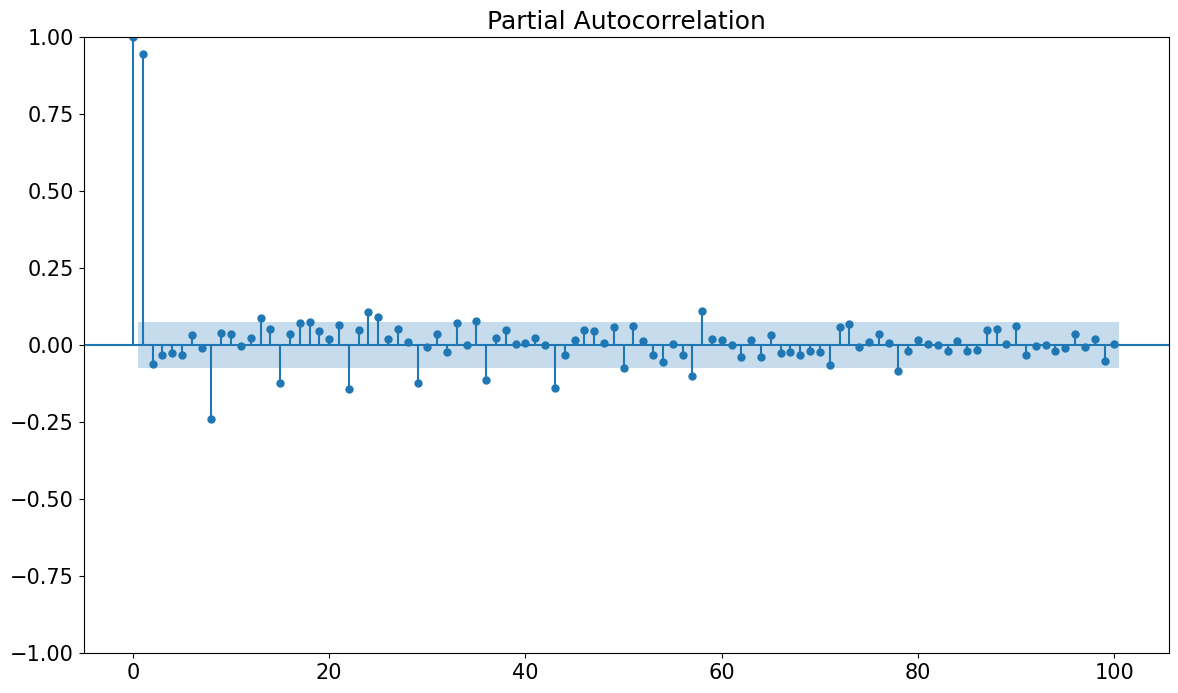

In [7]:
plot_acf(df['occupancy'], lags=100);
plot_pacf(df['occupancy'], lags=100);

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
# dickey-fuller test
# check if data is stationary
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

check_stationarity(df['occupancy'])

The series is stationary


In [10]:
from statsmodels.tsa.arima.model import ARIMA

In [11]:
# p <= 2 because first 2 lags are meaningful according to PACF
# d = 0 because data is stationary
# q <= 14 because first 14 lags are meaningful according to ACF, q = 13, because of Maximum-Likelihood-Error notification if q = 14
p, d, q = 2, 0, 13

arima = ARIMA(df['occupancy'], order=(p,d,q)) 
model_fit = arima.fit()
predictions = arima.fit().predict()

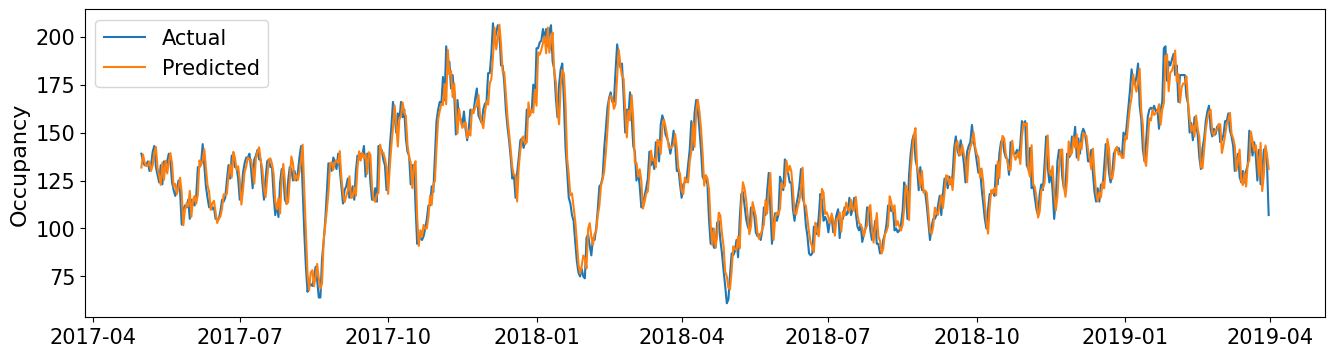

In [12]:
plt.figure(figsize=(16,4))
plt.plot(df, label="Actual") # No diff because we are working with stationary data
plt.plot(predictions, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error

In [14]:
rmse = root_mean_squared_error(df, predictions)
mape = mean_absolute_percentage_error(df, predictions)
[rmse, mape]

[8.574545046336578, 0.054302218861091905]

In [15]:
# SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [16]:
# SARIMA

sarima = SARIMAX(df['occupancy'],
                order=(1,0,1),
                seasonal_order=(2,0,13,7))
sarima_predictions = sarima.fit().predict()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95690D+00    |proj g|=  5.40661D-01

At iterate    5    f=  3.52789D+00    |proj g|=  2.83135D-02

At iterate   10    f=  3.50049D+00    |proj g|=  6.61448D-03

At iterate   15    f=  3.49854D+00    |proj g|=  7.51152D-03

At iterate   20    f=  3.49843D+00    |proj g|=  1.75134D-03

At iterate   25    f=  3.49799D+00    |proj g|=  3.91852D-03

At iterate   30    f=  3.49659D+00    |proj g|=  7.38606D-03

At iterate   35    f=  3.49369D+00    |proj g|=  2.41291D-02

At iterate   40    f=  3.49283D+00    |proj g|=  1.65844D-03

At iterate   45    f=  3.49103D+00    |proj g|=  2.18368D-02

At iterate   50    f=  3.49015D+00    |proj g|=  2.94909D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


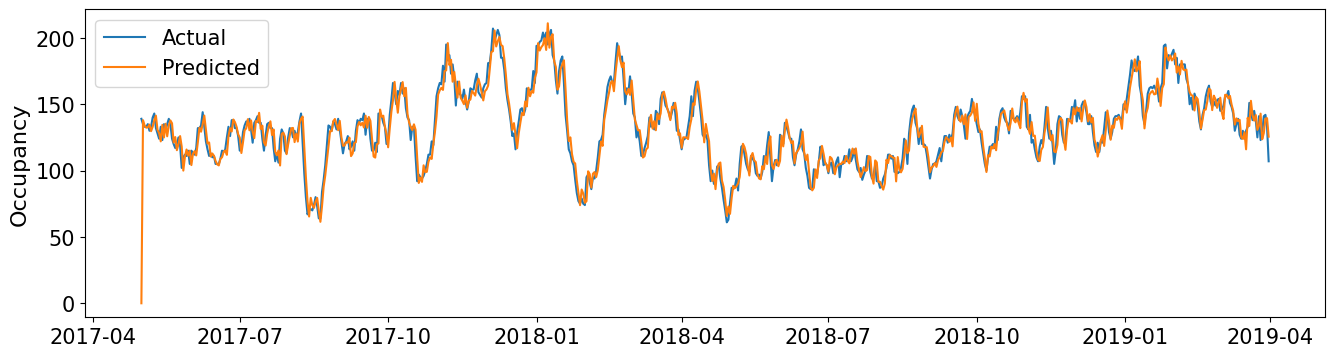

In [17]:
plt.figure(figsize=(16,4))
plt.plot(df, label="Actual")
plt.plot(sarima_predictions, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [18]:
rmse = root_mean_squared_error(df, sarima_predictions)
mape = mean_absolute_percentage_error(df, sarima_predictions)
[rmse, mape]

[9.462278441723807, 0.050913224736454925]

In [19]:
# Splitting data into test and training data

train_data = df.iloc[:-30]
test_data = df.iloc[-30:]

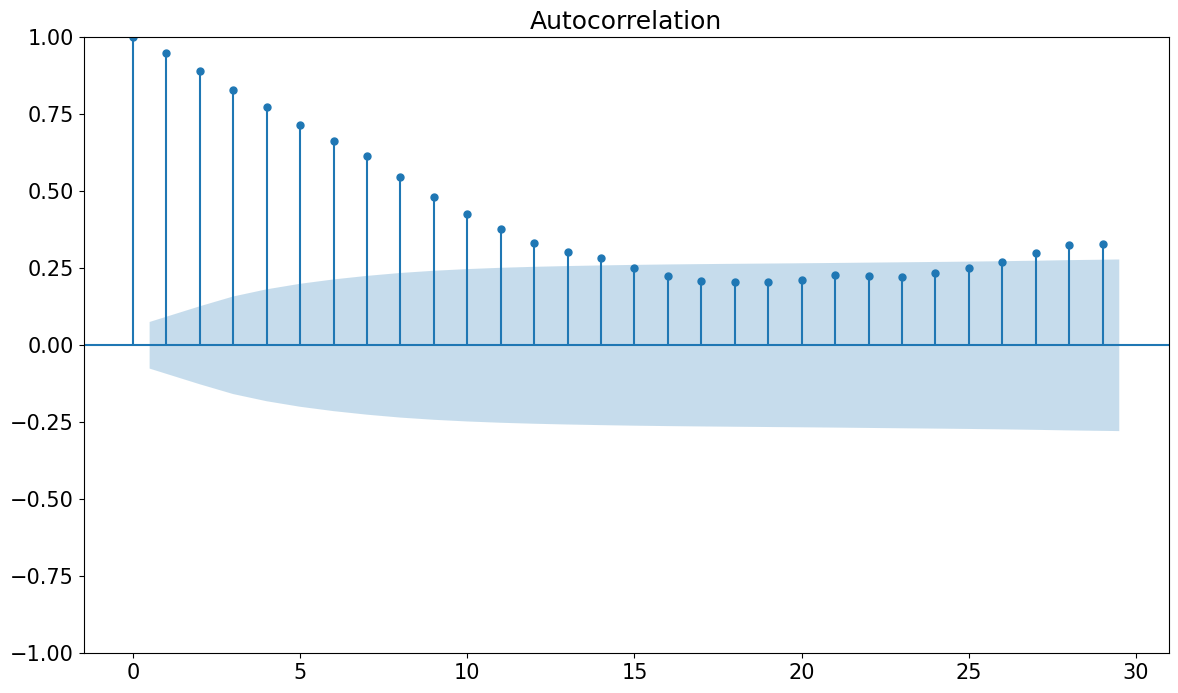

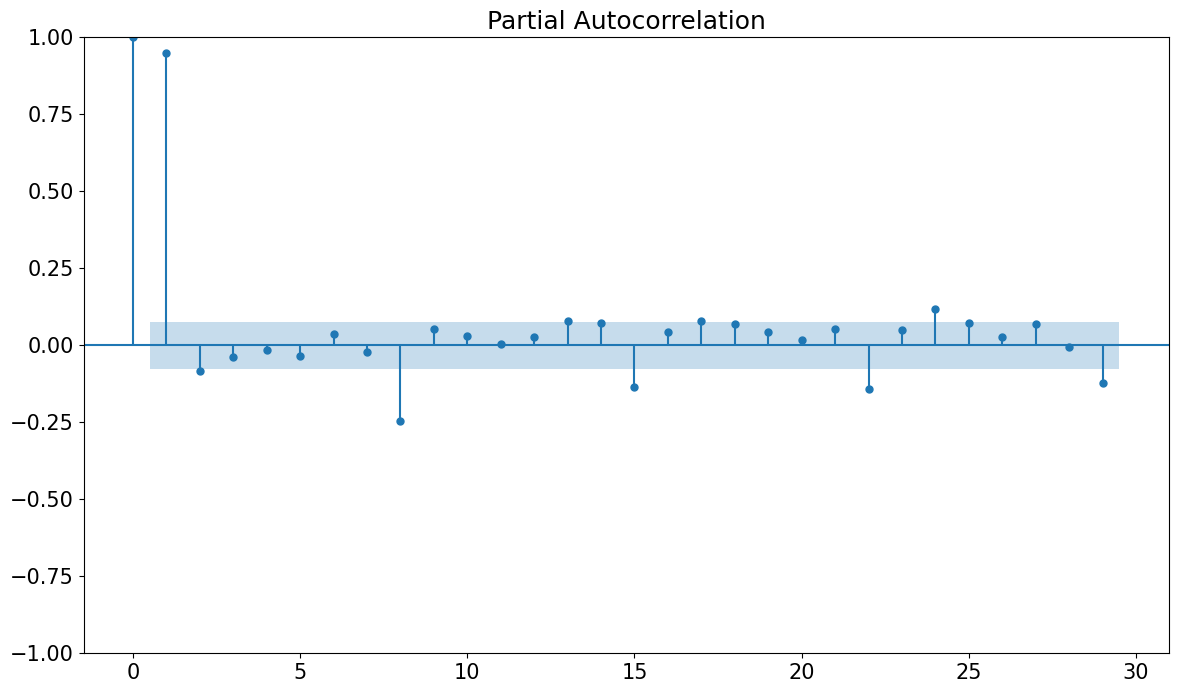

In [20]:
plot_acf(train_data['occupancy']);
plot_pacf(train_data['occupancy']);

In [21]:
# p <= 2 because first 2 lags are meaningful according to PACF
# d = 0 because data is stationary
# q <= 14 because first 14 lags are meaningful according to ACF, q = 13, because of Maximum-Likelihood-Error notification if q = 14
p, d, q = 2, 0, 13

arima_train_data = ARIMA(train_data['occupancy'], order=(p,d,q))
model_fit_train_data = arima_train_data.fit()

forecast_steps = 30
forecast_train_data = model_fit_train_data.forecast(steps=forecast_steps)

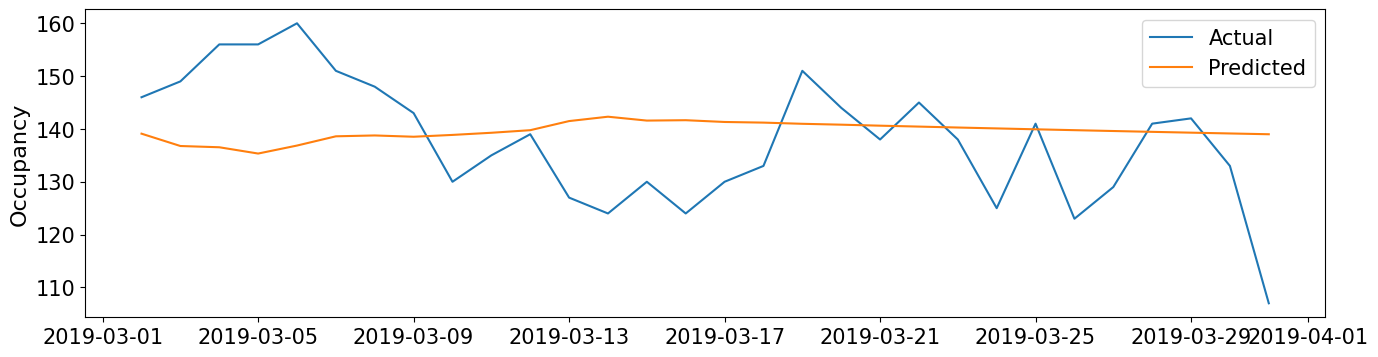

In [22]:
plt.figure(figsize=(16,4))
plt.plot(test_data, label="Actual") # No diff because we are working with stationary data
plt.plot(forecast_train_data, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [23]:
rmse = root_mean_squared_error(test_data[:30], forecast_train_data)
mape = mean_absolute_percentage_error(test_data[:30], forecast_train_data)
[rmse, mape]

[12.80481813336992, 0.07772818339795845]

In [24]:
# SARIMA

sarima = SARIMAX(train_data['occupancy'],
                order=(1,0,1),
                seasonal_order=(2,0,13,7))
model_fit_sarima = sarima.fit()

forecast_steps = 30
sarima_predictions_trained_data = model_fit_sarima.forecast(steps=forecast_steps)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.12836D+00    |proj g|=  7.65163D-01

At iterate    5    f=  3.75681D+00    |proj g|=  2.33091D-01

At iterate   10    f=  3.70914D+00    |proj g|=  8.72908D-02

At iterate   15    f=  3.70274D+00    |proj g|=  9.59709D-03

At iterate   20    f=  3.70169D+00    |proj g|=  9.38705D-03

At iterate   25    f=  3.68590D+00    |proj g|=  2.06990D-01

At iterate   30    f=  3.53506D+00    |proj g|=  4.95166D-02

At iterate   35    f=  3.50632D+00    |proj g|=  6.60015D-02

At iterate   40    f=  3.49581D+00    |proj g|=  1.42591D-02

At iterate   45    f=  3.49458D+00    |proj g|=  1.60030D-03


/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.49457D+00    |proj g|=  1.81497D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     59      1     0     0   1.815D-03   3.495D+00
  F =   3.4945670205583785     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


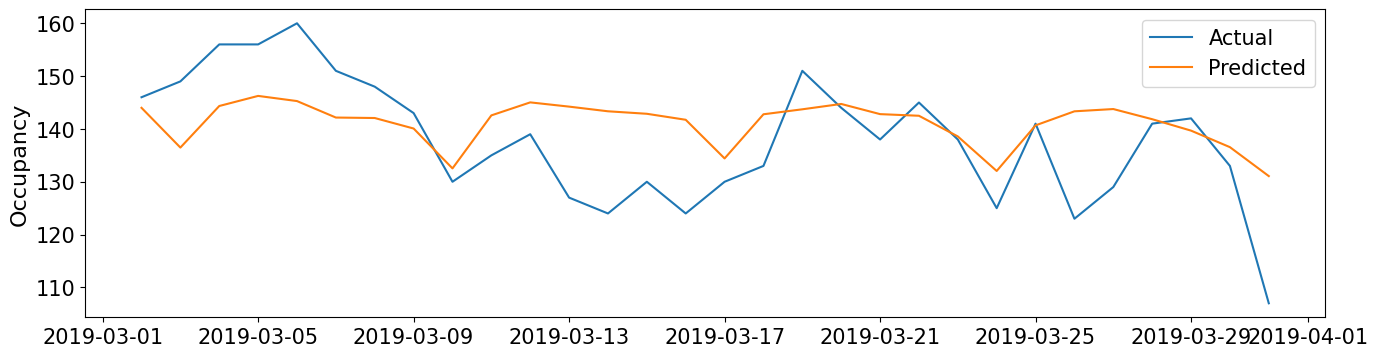

In [25]:
plt.figure(figsize=(16,4))
plt.plot(test_data, label="Actual") # No diff because we are working with stationary data
plt.plot(sarima_predictions_trained_data, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [26]:
rmse = root_mean_squared_error(test_data[:30], sarima_predictions_trained_data)
mape = mean_absolute_percentage_error(test_data[:30], forecast_train_data)
[rmse, mape]

[10.738215512421483, 0.07772818339795845]

In [27]:
# Forecast using time series split
# Adapted from https://www.geeksforgeeks.org/time-series-cross-validation/
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

In [28]:
tscv = TimeSeriesSplit(n_splits=3, test_size=30)

In [29]:
rmse_scores = []
mape_scores = []

for train_index, test_index in tscv.split(df):
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]
 
    model = ARIMA(train_data['occupancy'], order=(2, 0, 13))  # Example order for ARIMA
    fitted_model = model.fit()
 
    predictions = fitted_model.forecast(steps=len(test_data))
 
    rmse = root_mean_squared_error(test_data, predictions)
    rmse_scores.append(rmse)

    mape = mean_absolute_percentage_error(test_data, predictions)
    mape_scores.append(mape)
 
    print(f'Root Mean Squared Error for current split: {rmse}')
    print(f'Mean Absolute  for current split: {rmse}')
 
# Calculate average Root Mean Squared Error across all splits
average_rmse = np.mean(rmse_scores)
print(f'Average Mean Squared Error across all splits: {average_rmse}')

# Calculate average Mean Absolute Percentage Error across all splits
average_mape = np.mean(mape_scores)
print(f'Average Mean Squared Error across all splits: {average_mape}')

Root Mean Squared Error for current split: 33.349554876201275
Mean Absolute  for current split: 33.349554876201275


/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Squared Error for current split: 8.625120221339053
Mean Absolute  for current split: 8.625120221339053
Root Mean Squared Error for current split: 12.80481813336992
Mean Absolute  for current split: 12.80481813336992
Average Mean Squared Error across all splits: 18.259831076970084
Average Mean Squared Error across all splits: 0.09572579903548933


In [30]:
from pmdarima.arima import auto_arima

In [36]:
model = auto_arima(train_data['occupancy'], 
                   start_p=0, start_q=0, max_p=2, max_q=12,
                   test='adf',
                   seasonal=True,
                   m=7,
                   trace=True,
                   stepwise=False)

 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=6364.720, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=6081.613, Time=0.36 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=6027.578, Time=0.52 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=6048.724, Time=0.16 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=6029.247, Time=1.21 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=6035.285, Time=0.72 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=5703.431, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5522.131, Time=0.42 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=5497.000, Time=0.78 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=5490.086, Time=0.32 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=5494.806, Time=1.47 sec
 ARIMA(0,0,1)(2,0,0)[7] interc

In [32]:
p, d, q = 1, 0, 1

arima_train_data = ARIMA(train_data['occupancy'], order=(p,d,q))
model_fit_train_data = arima_train_data.fit()

forecast_steps = 30
forecast_train_data = model_fit_train_data.forecast(steps=forecast_steps)

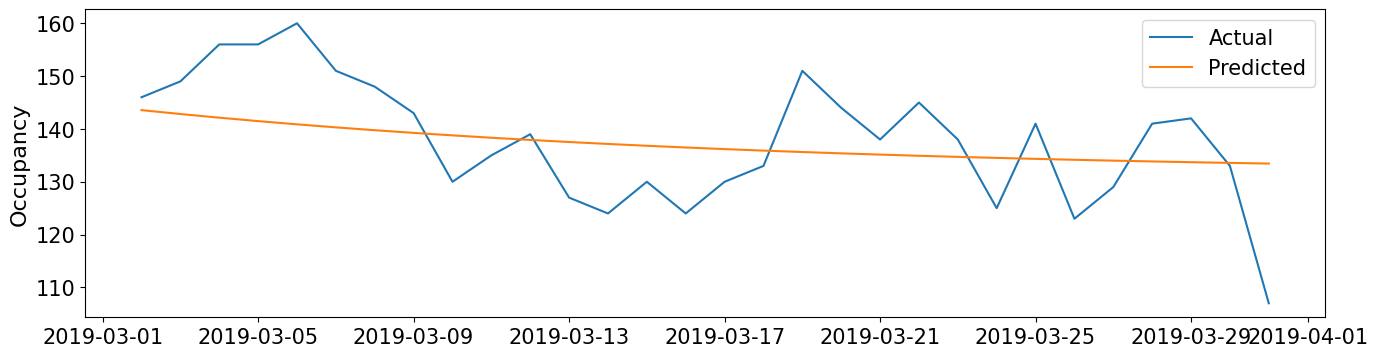

In [33]:
plt.figure(figsize=(16,4))
plt.plot(test_data, label="Actual") # No diff because we are working with stationary data
plt.plot(forecast_train_data, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [34]:
rmse = root_mean_squared_error(test_data[:30], forecast_train_data)
mape = mean_absolute_percentage_error(test_data[:30], forecast_train_data)
[rmse, mape]

[10.275295448588013, 0.0637724583055063]

In [35]:
rmse_scores = []
mape_scores = []

for train_index, test_index in tscv.split(df):
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]
 
    model = ARIMA(train_data['occupancy'], order=(1, 0, 1))  # Example order for ARIMA
    fitted_model = model.fit()
 
    predictions = fitted_model.forecast(steps=len(test_data))
 
    rmse = root_mean_squared_error(test_data, predictions)
    rmse_scores.append(rmse)

    mape = mean_absolute_percentage_error(test_data, predictions)
    mape_scores.append(mape)
 
    print(f'Root Mean Squared Error for current split: {rmse}')
    print(f'Mean Absolute  for current split: {rmse}')
 
# Calculate average Root Mean Squared Error across all splits
average_rmse = np.mean(rmse_scores)
print(f'Average Mean Squared Error across all splits: {average_rmse}')

# Calculate average Mean Absolute Percentage Error across all splits
average_mape = np.mean(mape_scores)
print(f'Average Mean Squared Error across all splits: {average_mape}')

Root Mean Squared Error for current split: 33.830324847357886
Mean Absolute  for current split: 33.830324847357886
Root Mean Squared Error for current split: 9.553606458082259
Mean Absolute  for current split: 9.553606458082259
Root Mean Squared Error for current split: 10.275295448588013
Mean Absolute  for current split: 10.275295448588013
Average Mean Squared Error across all splits: 17.886408918009383
Average Mean Squared Error across all splits: 0.09495255008513642


In [37]:
# SARIMA

sarima = SARIMAX(train_data['occupancy'],
                order=(2,0,0),
                seasonal_order=(1,0,2,7))
model_fit_sarima = sarima.fit()

forecast_steps = 30
sarima_predictions_trained_data = model_fit_sarima.forecast(steps=forecast_steps)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01194D+00    |proj g|=  7.87353D-01

At iterate    5    f=  3.52722D+00    |proj g|=  8.60961D-02

At iterate   10    f=  3.51200D+00    |proj g|=  7.28085D-03


 This problem is unconstrained.



At iterate   15    f=  3.51077D+00    |proj g|=  2.38346D-02

At iterate   20    f=  3.50366D+00    |proj g|=  8.75932D-03

At iterate   25    f=  3.50067D+00    |proj g|=  6.47993D-03

At iterate   30    f=  3.49548D+00    |proj g|=  2.59638D-02

At iterate   35    f=  3.49347D+00    |proj g|=  1.11190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     43      1     0     0   2.591D-05   3.493D+00
  F =   3.4934710692721147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


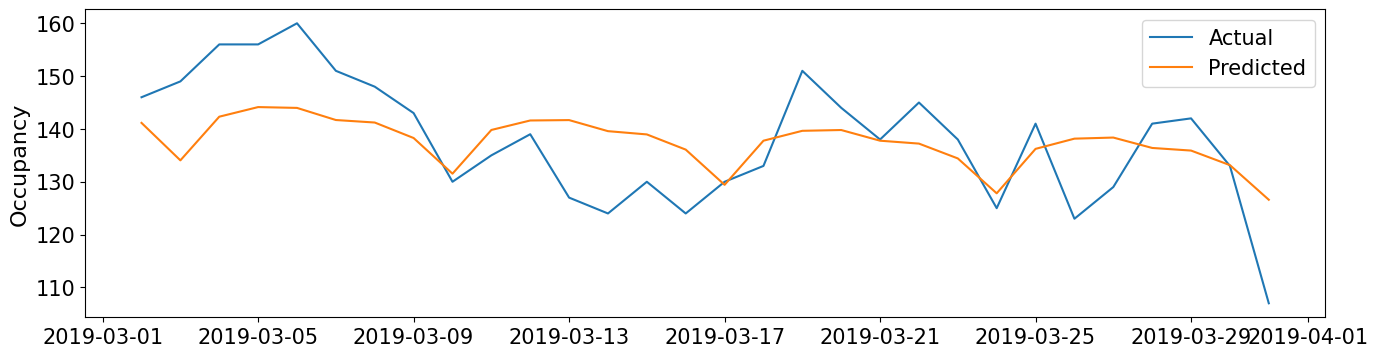

In [38]:
plt.figure(figsize=(16,4))
plt.plot(test_data, label="Actual") # No diff because we are working with stationary data
plt.plot(sarima_predictions_trained_data, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [39]:
rmse = root_mean_squared_error(test_data[:30], sarima_predictions_trained_data)
mape = mean_absolute_percentage_error(test_data[:30], forecast_train_data)
[rmse, mape]

[9.551446859567788, 0.0637724583055063]

In [41]:
rmse_scores = []
mape_scores = []

for train_index, test_index in tscv.split(df):
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]
 
    model = SARIMAX(train_data['occupancy'],
                order=(2,0,0),
                seasonal_order=(1,0,2,7))
    fitted_model = model.fit()
 
    predictions = fitted_model.forecast(steps=len(test_data))
 
    rmse = root_mean_squared_error(test_data, predictions)
    rmse_scores.append(rmse)

    mape = mean_absolute_percentage_error(test_data, predictions)
    mape_scores.append(mape)
 
    print(f'Root Mean Squared Error for current split: {rmse}')
    print(f'Mean Absolute  for current split: {rmse}')
 
# Calculate average Root Mean Squared Error across all splits
average_rmse = np.mean(rmse_scores)
print(f'Average Mean Squared Error across all splits: {average_rmse}')

# Calculate average Mean Absolute Percentage Error across all splits
average_mape = np.mean(mape_scores)
print(f'Average Mean Squared Error across all splits: {average_mape}')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04734D+00    |proj g|=  8.32851D-01

At iterate    5    f=  3.52470D+00    |proj g|=  8.32014D-02

At iterate   10    f=  3.51065D+00    |proj g|=  6.57469D-03

At iterate   15    f=  3.50855D+00    |proj g|=  2.28506D-02

At iterate   20    f=  3.49973D+00    |proj g|=  8.68174D-03

At iterate   25    f=  3.49723D+00    |proj g|=  7.53242D-03

At iterate   30    f=  3.49219D+00    |proj g|=  3.75916D-02

At iterate   35    f=  3.48897D+00    |proj g|=  1.37396D-03

At iterate   40    f=  3.48897D+00    |proj g|=  4.09873D-05

At iterate   45    f=  3.48894D+00    |proj g|=  3.33883D-03

At iterate   50    f=  3.48886D+00    |proj g|=  5.57662D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04470D+00    |proj g|=  8.05889D-01

At iterate    5    f=  3.53184D+00    |proj g|=  8.73495D-02


 This problem is unconstrained.



At iterate   10    f=  3.51664D+00    |proj g|=  1.74831D-03

At iterate   15    f=  3.51495D+00    |proj g|=  1.41238D-02

At iterate   20    f=  3.50831D+00    |proj g|=  1.36921D-03

At iterate   25    f=  3.50620D+00    |proj g|=  6.23778D-03

At iterate   30    f=  3.49967D+00    |proj g|=  3.30133D-03

At iterate   35    f=  3.49949D+00    |proj g|=  6.16661D-05

At iterate   40    f=  3.49948D+00    |proj g|=  2.41488D-03

At iterate   45    f=  3.49942D+00    |proj g|=  1.95456D-03

At iterate   50    f=  3.49941D+00    |proj g|=  7.11357D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     70   

/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01194D+00    |proj g|=  7.87353D-01

At iterate    5    f=  3.52722D+00    |proj g|=  8.60961D-02

At iterate   10    f=  3.51200D+00    |proj g|=  7.28085D-03

At iterate   15    f=  3.51077D+00    |proj g|=  2.38346D-02

At iterate   20    f=  3.50366D+00    |proj g|=  8.75932D-03

At iterate   25    f=  3.50067D+00    |proj g|=  6.47993D-03

At iterate   30    f=  3.49548D+00    |proj g|=  2.59638D-02

At iterate   35    f=  3.49347D+00    |proj g|=  1.11190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 